# Harware Specs

![hardware_specs](./harware_specs.png)


In [1]:
import torch
import os
import matplotlib.pyplot as plt
import tqdm
import numpy as np
import random
import time
from copy import deepcopy
from torch.nn.utils import prune

np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

In [2]:
mnist_config = {
    'input_size': 400,
    'batch_size': 64,
    'lr': 0.001,
    'hidden_layers': 2,
    'hidden_size': 1024,
    'epochs': 2,
    'log_interval': 10, # log every 10 batches
    'output_size': 10
}

sst_config = {
    'batch_size': 64,
    'lr': 0.001,
    'hidden_layers': 3,
    'hidden_size': 256,
    'epochs': 2,
    'log_interval': 10,
    'output_size': 2
}

In [3]:
def print_size_of_model(model, label=""):
    torch.save(model.state_dict(), "temp.p")
    size=os.path.getsize("temp.p")
    print("model: ",label,' \t','Size (MB):', size/1e6)
    os.remove('temp.p')
    return size

# Dataset

In [4]:
class SSTDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, data_type='train', suffix='tsv', vocab=None, top_k=0, remove_stopwords=False):
        self.datapath = os.path.join(data_dir, data_type + '.' + suffix)
        self.data_type = data_type
        self.sentences = []
        self.labels = []

        with open(self.datapath) as data_f:
            for line in data_f:
                sentence, label = line.strip().split('\t')
                self.sentences.append(sentence)
                self.labels.append(label)
        self.sentences = self.sentences[1:]
        self.labels = self.labels[1:]
        if vocab is None:
            self.vocab = self.build_vocab()
        else:
            self.vocab = vocab
        if top_k > 0:
            self.vocab = self.vocab[:top_k]
        if remove_stopwords:
            self.vocab = self.remove_stopwords()
        self.word2idx = {word: idx for idx, word in enumerate(self.vocab)}
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}
        
        # add OOV token
        if vocab is None:
            self.vocab.append('<OOV>')
            self.word2idx['<OOV>'] = len(self.vocab) - 1
            self.idx2word[len(self.vocab) - 1] = '<OOV>'
            
    def remove_stopwords(self):
        # remove stopwords obtained from nltk
        from nltk.corpus import stopwords
        stop_words = set(stopwords.words('english'))
        return [word for word in self.vocab if word not in stop_words]

    def __len__(self):
        return len(self.sentences)

    def one_hot_encode(self, word):
        vector = torch.zeros(len(self.vocab))
        if word in self.word2idx:
            vector[self.word2idx[word]] += 1
        else:
            vector[self.word2idx['<OOV>']] += 1
        return vector
    
    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        label = self.labels[idx]
        
        encoded_sentence = torch.sum(torch.stack([self.one_hot_encode(word) for word in sentence.split()]), dim=0)
        encoded_label = torch.tensor(int(label)) # 0: negative, 1: positive
        return encoded_sentence, encoded_label

    def build_vocab(self):
        vocab = {}
        for sentence in self.sentences:
            for word in sentence.split():
                if word not in vocab:
                    vocab[word] = 1
                else:
                    vocab[word] += 1
        return sorted(vocab, key=vocab.get, reverse=True)
        

In [5]:
class MNISTDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, data_type='train', suffix='csv', transforms=None):
        self.datapath = os.path.join(data_dir, f'mnist_{data_type}.{suffix}')
        self.labels = []
        self.data = []
        self.transforms = transforms
        
        with open(self.datapath) as data_f:
            line_cnt = 0
            for line in data_f:
                if line_cnt > 0:
                    data = line.strip().split(',')
                    self.labels.append(data[0])
                    self.data.append(torch.tensor([float(dp) for dp in data[1:]]))
                line_cnt += 1
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        label = self.labels[idx]
        data = self.data[idx]
        # normalize the data
        data = (data - torch.mean(data)) / torch.std(data)
        if self.transforms is not None:
            # reconstruct to image and do transforms
            data = data.reshape(1, 28, 28)
            data = self.transforms(data)
            # flatten
            data = data.reshape(-1)
        return data, torch.tensor(int(label))

# Model

In [6]:
class MLP(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_hidden_layers, output_size):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_hidden_layers = num_hidden_layers
        self.output_size = output_size
        self.total_flops = 0
        self.layers = torch.nn.ModuleList()
        for layer_idx in range(self.num_hidden_layers):
            if layer_idx == 0:
                self.layers.append(torch.nn.Linear(self.input_size, self.hidden_size))
                self.total_flops += self.input_size * self.hidden_size
            else:
                self.layers.append(torch.nn.Linear(self.hidden_size, self.hidden_size))
                self.total_flops += self.hidden_size * self.hidden_size
            self.layers.append(torch.nn.ReLU())
            self.total_flops += self.hidden_size
        self.layers.append(torch.nn.Linear(self.hidden_size, self.output_size))
        self.total_flops += self.hidden_size * self.output_size
        self.softmax = torch.nn.Softmax(dim=1)
        self.total_flops += self.output_size * np.log2(self.output_size)
    
    def forward(self, x):
        # x: (batch_size, input_size)
        for layer in self.layers:
            x = layer(x)
        x = self.softmax(x) 
        return x
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)
    
    def save_initial_weights(self, name):
        # save the weights of a model in a file
        torch.save(self.state_dict(), name)

# Trainer

In [7]:
class Trainer:
    def __init__(self, 
                 model, 
                 train_dl, 
                 valid_dl, 
                 config, 
                 ckpt_path='ckpt', 
                 device='cuda', 
                 save_ckpts=False,
                 no_train=False):
        self.model = model.to(device)
        self.initial_ckpt = deepcopy(model.state_dict())
        self.train_dl = train_dl
        self.valid_dl = valid_dl
        self.config = config
        self.no_train = no_train
        if not no_train:
            self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.config['lr'])
            self.criterion = torch.nn.CrossEntropyLoss().to(device)
        self.training_time = 0
        self.training_time_per_epoch = []
        self.total_inference_time = 0
        self.inference_time = []
        self.avg_inference_time_per_epoch = []
        self.ckpt_path = ckpt_path
        self.best_acc = 0
        self.device = device
        self.save_ckpt = save_ckpts

    def train(self):
        start = time.time()
        for epoch in range(self.config['epochs']):
            start_time = time.time()
            self.train_one_epoch()
            end_time = time.time()
            self.training_time_per_epoch.append(end_time - start_time)
            acc = self.validate()
            if acc > self.best_acc:
                self.best_acc = acc
                if self.save_ckpt:
                    self.save(epoch)
        end = time.time()
        self.training_time = end - start

    def train_one_epoch(self):
        batch_bar = tqdm.tqdm(total=len(self.train_dl), dynamic_ncols=True, leave=True, position=0, desc='Train',
                              ncols=5)
        num_correct = 0
        total_loss = 0
        total_inference_epoch = 0

        for idx, (train_data, train_label) in enumerate(self.train_dl):
            unit_num_correct, unit_total_loss, batch_inference_time = self.train_one_batch(train_data, train_label)
            total_inference_epoch += batch_inference_time
            num_correct += unit_num_correct
            total_loss += unit_total_loss
            batch_bar.set_postfix(
                acc=f"{100 * num_correct / (self.config['batch_size'] * (idx + 1)):.4f}",
                loss=f"{total_loss / (self.config['batch_size'] * (idx + 1)):.4f}",
                num_correct=f"{num_correct}",
                lr=f"{self.optimizer.param_groups[0]['lr']:.4f}"
            )
            batch_bar.update()

        self.avg_inference_time_per_epoch.append(total_inference_epoch / len(self.train_dl.dataset))
        batch_bar.close()

    def train_one_batch(self, train_data, train_label):
        train_data = train_data.to(self.device)
        train_label = train_label.to(self.device)
        self.optimizer.zero_grad()
        inference_start = time.time()
        output = self.model(train_data)
        inference_end = time.time()
        self.total_inference_time += inference_end - inference_start
        # l2 regularization
        # loss = self.criterion(output, train_label) - 0.001 * torch.norm(self.model.layers[0].weight, p=2)
        loss = self.criterion(output, train_label)
        num_correct = torch.sum(torch.argmax(output, dim=1) == train_label).item()
        total_loss = float(loss.item())
        loss.backward()
        self.optimizer.step()

        return num_correct, total_loss, inference_end - inference_start

    def validate(self):
        # report accuracy
        correct_count = 0
        valid_loss = 0
        num_samples = 0
        for idx, (valid_data, valid_label) in enumerate(self.valid_dl):
            num_samples += len(valid_data)
            valid_data = valid_data.to(self.device)
            valid_label = valid_label.to(self.device)
            output = self.model(valid_data)
            pred = torch.argmax(output, dim=1)  # (batch_size)
            correct_count += torch.sum(pred == valid_label).item()
            if not self.no_train:
                loss = self.criterion(output, valid_label).item()
                valid_loss += loss
        if not self.no_train:
            valid_loss /= num_samples
        acc = correct_count / len(self.valid_dl.dataset)
        print(f'\nValidation Loss: {valid_loss if not self.no_train else "n/a"}\t Validation Accuracy: {acc:.4f}')
        self.valid_acc = acc
        return acc
    
    def calculate_inference_latency(self, val_dl):
        # calculate inference latency per batch
        total_inference_time = 0
        num_of_batches = 0
        for idx, (valid_data, valid_label) in enumerate(val_dl):
            num_of_batches += 1
            valid_data = valid_data.to(self.device)
            inference_start = time.time()
            _ = self.model(valid_data)
            inference_end = time.time()
            total_inference_time += inference_end - inference_start
        return total_inference_time / num_of_batches

    def save(self, epoch):
        ckpt_dir = os.path.join(self.ckpt_path, f'{time.strftime("%m-%d-%H-%M", time.localtime())}')
        if not os.path.exists(ckpt_dir):
            os.makedirs(ckpt_dir)
        print(f'Saving model at Epoch {epoch}')
        ckpt_path = os.path.join(ckpt_dir, f'best_acc.pt')
        torch.save(self.model.state_dict(), ckpt_path)

    def get_training_stats(self):
        # we need flops, avg inference per sample and accuracy
        return {
            'num_parameters': self.model.count_parameters(),
            'num_flops': self.model.total_flops,
            'training_time': self.training_time,
            'training_time_per_epoch': np.mean(self.training_time_per_epoch),
            'best_acc': self.best_acc,
            'average_inference_time_per_sample': self.total_inference_time / (self.config['epochs'] * len(self.train_dl.dataset)),
        }
    def report(self):
        print(f'Number of parameters: {self.model.count_parameters()}')
        print(f'Total number of FLOPs: {self.model.total_flops}')
        print(f'Average training time per epoch: {np.mean(self.training_time_per_epoch)} seconds')
        print(f'Training time: {self.training_time} seconds')
        print(
            f'Average inference time per sample: {self.total_inference_time / (self.config["epochs"] * len(self.train_dl.dataset))} seconds')


# Baseline

In [8]:
# dataloaders
from torchvision import transforms

sst_train_dataset = SSTDataset(data_dir='SST-2', data_type='train', top_k=5000)
sst_dev_dataset = SSTDataset(data_dir='SST-2', data_type='dev', vocab=sst_train_dataset.vocab)
mnist_train_dataset = MNISTDataset(data_dir='MNIST', data_type='train', transforms=transforms.CenterCrop((20, 20)))
mnist_valid_dataset = MNISTDataset(data_dir='MNIST', data_type='test', transforms=transforms.CenterCrop((20, 20)))


sst_dataloader = torch.utils.data.DataLoader(
    dataset=sst_train_dataset,
    batch_size=sst_config['batch_size'],
    shuffle=True
)
sst_dev_dataloader = torch.utils.data.DataLoader(
    dataset=sst_dev_dataset,
    batch_size=sst_config['batch_size'],
    shuffle=False
)
mnist_dataloader = torch.utils.data.DataLoader(dataset=mnist_train_dataset,
                                               batch_size=mnist_config['batch_size'],
                                               shuffle=True)
mnist_valid_dataloader = torch.utils.data.DataLoader(dataset=mnist_valid_dataset,
                                                     batch_size=mnist_config['batch_size'],
                                                     shuffle=False)


/Users/vincenthuang/Development/on-device-ml/on-device-ml/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [9]:
len(mnist_train_dataset)

59999

In [10]:
device = 'cpu'

In [11]:
# Train

# MNIST model
# mnist_model = MLP(input_size=mnist_config['input_size'], hidden_size=mnist_config['hidden_size'], num_hidden_layers=mnist_config['hidden_layers'], output_size=mnist_config['output_size'])

# mnist_trainer = Trainer(
#     model=mnist_model,
#     train_dl=mnist_dataloader,
#     valid_dl=mnist_valid_dataloader,
#     config=mnist_config,
#     device=device
# )

# mnist_model.save_initial_weights('initial_weights_mnist.p')

# mnist_trainer.train()
# mnist_trainer.report()

# SST model
sst_model = MLP(input_size=len(sst_train_dataset.vocab), 
                hidden_size=sst_config['hidden_size'], 
                num_hidden_layers=sst_config['hidden_layers'], 
                output_size=sst_config['output_size'])

sst_model.save_initial_weights('initial_weights_sst.p')

sst_trainer = Trainer(
    model=sst_model,
    train_dl=sst_dataloader,
    valid_dl=sst_dev_dataloader,
    config=sst_config,
    device=device
)
sst_trainer.train()
sst_trainer.report()

Train: 100%|██████████| 1053/1053 [00:19<00:00, 55.05it/s, acc=82.4519, loss=0.0074, lr=0.0010, num_correct=55566]



Validation Loss: 0.008237812394669296	 Validation Accuracy: 0.7924


Train: 100%|██████████| 1053/1053 [00:25<00:00, 41.99it/s, acc=89.3133, loss=0.0064, lr=0.0010, num_correct=60190]



Validation Loss: 0.00811861486199799	 Validation Accuracy: 0.8016
Number of parameters: 1412610
Total number of FLOPs: 1412610.0
Average training time per epoch: 22.120564341545105 seconds
Training time: 44.814276933670044 seconds
Average inference time per sample: 1.7254929136922997e-05 seconds


In [12]:
# report baseline stats
def baseline_stats(trainer):
    # get model accuracy, avg latency per sample, disk size
    model_stats = trainer.get_training_stats()
    return {
        'Iteration': 0,
        'Sparsity': 0,
        'Accuracy': trainer.valid_acc,
        'Latency': model_stats['average_inference_time_per_sample'],
        'Disk Size (MB)': print_size_of_model(trainer.model, label='Baseline') / 1e6
    }

In [14]:
baseline_dict = {
    # 'mnist_baseline': baseline_stats(mnist_trainer),
    'sst_baseline': baseline_stats(sst_trainer)
}
baseline_dict

model:  Baseline  	 Size (MB): 5.652849


{'sst_baseline': {'Iteration': 0,
  'Sparsity': 0,
  'Accuracy': 0.801605504587156,
  'Latency': 1.7254929136922997e-05,
  'Disk Size (MB)': 5.652849}}

In [15]:
# for name, param in mnist_model.named_parameters():
#     print(name, param)


In [16]:
for name, param in sst_model.named_parameters():
    print(name, param)

layers.0.weight Parameter containing:
tensor([[ 0.0202,  0.0051,  0.0051,  ...,  0.0080, -0.0049, -0.0141],
        [-0.0163,  0.0401, -0.0087,  ...,  0.0059,  0.0214, -0.0524],
        [-0.0215,  0.0113,  0.0286,  ...,  0.0181, -0.0115, -0.0229],
        ...,
        [ 0.0043, -0.0178,  0.0462,  ..., -0.0072,  0.0062, -0.0164],
        [-0.0152,  0.0100,  0.0100,  ...,  0.0018,  0.0052, -0.0080],
        [-0.1204,  0.0146,  0.0293,  ..., -0.0009, -0.0051,  0.0059]],
       requires_grad=True)
layers.0.bias Parameter containing:
tensor([-0.0121, -0.0484,  0.0018, -0.0075, -0.0060, -0.0164, -0.0737,  0.0063,
        -0.0830,  0.0001, -0.0385,  0.0046, -0.0482, -0.0432,  0.0149, -0.0132,
        -0.0215, -0.0331,  0.0064,  0.0037, -0.0542,  0.0784,  0.0113, -0.0152,
        -0.0207, -0.0414,  0.0042, -0.0285, -0.0236,  0.0026,  0.0009, -0.0728,
        -0.0071,  0.0492,  0.0004,  0.0002,  0.0214, -0.0157, -0.0011, -0.0556,
        -0.0435, -0.0253,  0.0124,  0.0110, -0.0291, -0.0325, -0.

# Magnitude pruning on SST2/MNIST

In [17]:
# for m in mnist_model.named_modules():
#     print(f'm: {m}, m[1] children: {len(list(m[1].children()))}')

In [ ]:
# input_mnist_model_input = [(m[1], "weight") for m in mnist_model.named_modules() if len(list(m[1].children()))==0]
# input_mnist_model_input

[(Linear(in_features=400, out_features=1024, bias=True), 'weight'),
 (ReLU(), 'weight'),
 (Linear(in_features=1024, out_features=1024, bias=True), 'weight'),
 (ReLU(), 'weight'),
 (Linear(in_features=1024, out_features=10, bias=True), 'weight'),
 (Softmax(dim=1), 'weight')]

In [18]:
# mnist_copy = deepcopy(mnist_model)
# prune_input = []
# for layer in mnist_copy.layers:
#     if isinstance(layer, torch.nn.Linear):
#         prune_input.append((layer, 'weight'))

# prune.global_unstructured(
#     prune_input,
#     pruning_method=prune.L1Unstructured,
#     amount=0.33,
# )

In [19]:
# for name, param in mnist_copy.named_parameters():
#     print(name, param)

In [20]:
# for name, param in mnist_copy.named_buffers():
#     print(name, param)

In [21]:
# extract the pruning logic

def prune_model(model, amount=0.33):
    prune_input = []
    for layer in model.layers:
        if isinstance(layer, torch.nn.Linear):
            prune_input.append((layer, 'weight'))
    print(prune_input)
    prune.global_unstructured(
        prune_input,
        pruning_method=prune.L1Unstructured,
        amount=amount,
    )
    return model

def prune_and_evaluate(model, 
                       train_dl, 
                       valid_dl, 
                       model_config,
                       amount=0.33,
                       device='cpu',
                       repeat=1,
                       retrain=False):
    # 0.33 + (1 - 0.33) * 0.33 + ()
    model_copy = deepcopy(model)
    stats = {}

    # get baseline stats
    trainer = Trainer(
        model=model_copy,
        train_dl=train_dl,
        valid_dl=valid_dl,
        config=model_config,
        device=device,
        no_train=True
    )
    trainer.validate()
    stats[0] = baseline_stats(trainer)
    pruned_amount = 0
    for iteration in range(1, repeat + 1):
        stats[iteration] = {}
        prune_input = []
        for layer in model_copy.layers:
            if isinstance(layer, torch.nn.Linear):
                prune_input.append((layer, 'weight'))
        pruned_amount += (1 - pruned_amount) * amount
        prune.global_unstructured(
            prune_input,
            pruning_method=prune.L1Unstructured,
            amount=pruned_amount,
        )
        # assert prune_model(model_copy, amount=pruned_amount) != model_copy
        
        # calculate sparsity level
        weight_masks = {name: buffer for name, buffer in model_copy.named_buffers() if name.endswith('weight_mask')}
        # for each parameter
        stats[iteration]['each_parameter'] = {}
        for name, param in model_copy.named_parameters():
            if name.endswith('weight_orig'):
                layer_name = f"{'.'.join(name.split('.')[:-1])}.weight_mask"
                stats[iteration]['each_parameter'][layer_name] = (weight_masks[layer_name].eq(0).sum() / weight_masks[layer_name].numel()).item()
            else:
                stats[iteration]['each_parameter'][name] = 0

        # for all pruned parameters overall
        stats[iteration]['all_pruned_parameters'] = (sum([mask.eq(0).sum() for mask in weight_masks.values()]) / sum([mask.numel() for mask in weight_masks.values()])).item()    
        
        # for the model overall
        stats[iteration]['model_overall'] = (sum([mask.eq(0).sum() for mask in weight_masks.values()]) / sum([model_copy.count_parameters()])).item()

        for p in prune_input:
            prune.remove(*p)

        sd = model_copy.state_dict()
        for item in sd:
            sd[item] = model_copy.state_dict()[item].to_sparse()
        
        torch.save(sd, 'sparse_model.p')
        stats[iteration]['Disk Size (MB)'] = os.path.getsize('sparse_model.p') / 1e6
        trainer_pruned = Trainer(
            model=model_copy,
            train_dl=train_dl,
            valid_dl=valid_dl,
            config=model_config,
            device=device,
            no_train=True
        )
        stats[iteration]['Accuracy'] = trainer_pruned.validate()
        stats[iteration]['Latency'] = trainer_pruned.calculate_inference_latency(valid_dl)
    return stats
    
# mnist_pruned_stats = prune_and_evaluate(mnist_model, 
#                                         mnist_dataloader,
#                                         mnist_valid_dataloader,
#                                         mnist_config,
#                                         amount=0.33,
#                                         repeat=10)
sst_pruned_stats = prune_and_evaluate(sst_model, 
                                      sst_dataloader,
                                      sst_dev_dataloader,
                                      sst_config,
                                      amount=0.33,
                                      repeat=10)


Validation Loss: n/a	 Validation Accuracy: 0.8016
model:  Baseline  	 Size (MB): 5.652849


/Users/vincenthuang/Development/on-device-ml/on-device-ml/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/vincenthuang/Development/on-device-ml/on-device-ml/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Validation Loss: n/a	 Validation Accuracy: 0.8028

Validation Loss: n/a	 Validation Accuracy: 0.7924

Validation Loss: n/a	 Validation Accuracy: 0.7878

Validation Loss: n/a	 Validation Accuracy: 0.7718

Validation Loss: n/a	 Validation Accuracy: 0.7706

Validation Loss: n/a	 Validation Accuracy: 0.7477

Validation Loss: n/a	 Validation Accuracy: 0.7397

Validation Loss: n/a	 Validation Accuracy: 0.7408

Validation Loss: n/a	 Validation Accuracy: 0.7167

Validation Loss: n/a	 Validation Accuracy: 0.7087


In [ ]:
# mnist_pruned_stats

{0: {'Iteration': 0,
  'Sparsity': 0,
  'Accuracy': 0.9392939293929393,
  'Latency': 0.0,
  'Disk Size (MB)': 5.883839},
 1: {'each_parameter': {'layers.0.bias': 0,
   'layers.0.weight_mask': 0.2639233469963074,
   'layers.2.bias': 0,
   'layers.2.weight_mask': 0.3561983108520508,
   'layers.4.bias': 0,
   'layers.4.weight_mask': 0.29033201932907104},
  'all_pruned_parameters': 0.32999980449676514,
  'model_overall': 0.329537957906723,
  'Disk Size (MB)': 19.705415,
  'Accuracy': 0.9397939793979398,
  'Latency': 0.00044428618850222057},
 2: {'each_parameter': {'layers.0.bias': 0,
   'layers.0.weight_mask': 0.4530322253704071,
   'layers.2.bias': 0,
   'layers.2.weight_mask': 0.5899600982666016,
   'layers.4.bias': 0,
   'layers.4.weight_mask': 0.4945312440395355},
  'all_pruned_parameters': 0.551099956035614,
  'model_overall': 0.5503286719322205,
  'Disk Size (MB)': 13.212103,
  'Accuracy': 0.9381938193819382,
  'Latency': 0.00044238795140746294},
 3: {'each_parameter': {'layers.0.bia

In [ ]:
sst_pruned_stats

{0: {'Iteration': 0,
  'Sparsity': 0,
  'Accuracy': 0.8027522935779816,
  'Latency': 0.0,
  'Disk Size (MB)': 5.652849},
 1: {'each_parameter': {'layers.0.bias': 0,
   'layers.0.weight_mask': 0.34196674823760986,
   'layers.2.bias': 0,
   'layers.2.weight_mask': 0.2008209228515625,
   'layers.4.bias': 0,
   'layers.4.weight_mask': 0.2266082763671875,
   'layers.6.bias': 0,
   'layers.6.weight_mask': 0.17578125},
  'all_pruned_parameters': 0.3299998641014099,
  'model_overall': 0.3298199772834778,
  'Disk Size (MB)': 18.932879,
  'Accuracy': 0.801605504587156,
  'Latency': 0.0007226807730538505},
 2: {'each_parameter': {'layers.0.bias': 0,
   'layers.0.weight_mask': 0.5695853233337402,
   'layers.2.bias': 0,
   'layers.2.weight_mask': 0.347076416015625,
   'layers.4.bias': 0,
   'layers.4.weight_mask': 0.3957672119140625,
   'layers.6.bias': 0,
   'layers.6.weight_mask': 0.326171875},
  'all_pruned_parameters': 0.551099956035614,
  'model_overall': 0.5507996082305908,
  'Disk Size (MB)'

In [22]:
# make a dataframe with column iteration, Sparsity(%), Accuracy, Latency, Disk Size (MB)
import pandas as pd

def make_dataframe(stats_dict):
    # only keep the sparsity of all_pruned_parameters and remove the rest of the sparsity calculations
    # only keep the accuracy, latency, disk size
    df = pd.DataFrame.from_dict(stats_dict, orient='index').reset_index()
    # remove the Iteration column
    df = df.drop(columns=['Iteration'])
    df = df.rename(columns={'index': 'Iteration'})
    df = df[['Iteration', 'all_pruned_parameters', 'Accuracy', 'Latency', 'Disk Size (MB)']]
    df = df.rename(columns={'all_pruned_parameters': 'Sparsity (%)'})
    # replace the NaN with 0 for Sparsity (%) and times 100
    df['Sparsity (%)'] = df['Sparsity (%)'].fillna(0) * 100
    # replace the NaN with 0 for Disk Size (MB)
    df['Disk Size (MB)'] = df['Disk Size (MB)'].fillna(0)
    return df

# mnist_pruned_df = make_dataframe(mnist_pruned_stats)
sst_pruned_df = make_dataframe(sst_pruned_stats)

In [23]:
# mnist_pruned_df

In [24]:
sst_pruned_df

,Iteration,Sparsity (%),Accuracy,Latency,Disk Size (MB)
0,0,0.000000,0.801606,0.000000,5.652849
1,1,32.999986,0.802752,0.001001,18.932943
2,2,55.109996,0.792431,0.000893,12.689743
3,3,69.923717,0.787844,0.000849,8.506895
4,4,79.848850,0.771789,0.000931,5.704271
5,5,86.498755,0.770642,0.000842,3.826511
6,6,90.954143,0.747706,0.000894,2.568527
7,7,93.939257,0.739679,0.000916,1.725583
8,8,95.939344,0.740826,0.000969,1.160783
9,9,97.279364,0.716743,0.000927,0.782607


# IMP with Rewind

In [30]:
def imp_rewind(model, train_dl, valid_dl, model_config, amount=0.33, device='cpu'):
    # train the model with imp_pruning with rewind option enabled
    trainer = Trainer(
        model=model,
        train_dl=train_dl,
        valid_dl=valid_dl,
        config=model_config,
        device=device,
        prune_with_rewind=True,
        amount=amount
    )

    trainer.train()
    trainer.report()
    return trainer

def imp_rewind_experiment(model, train_dl, valid_dl, model_config, amount=0.33, device='cpu', repeat=10, rewind=True):
    pruned_amount = 0
    stats = {}

    # get baseline stats
    model_copy = deepcopy(model)
    trainer = Trainer(
        model=model_copy,
        train_dl=train_dl,
        valid_dl=valid_dl,
        config=model_config,
        device=device,
    )
    trainer.train_one_epoch()
    trainer.train_one_epoch()
    trainer.validate()
    stats[0] = baseline_stats(trainer)
    
    for iteration in range(1, repeat + 1):
        print(f'running experiments for iteration: {iteration}')
        stats[iteration] = {}
        model_copy = deepcopy(model)
        pruned_amount += (1 - pruned_amount) * amount
        
        # trainer = imp_rewind(model_copy, train_dl, valid_dl, model_config, amount=pruned_amount, device=device)
        trainer = Trainer(
            model=model_copy,
            train_dl=train_dl,
            valid_dl=valid_dl,
            config=model_config,
            device=device
        )

        for epoch in range(model_config['epochs']):
            trainer.train_one_epoch()
            # prune
            prune_input = []
            for layer in trainer.model.layers:
                if isinstance(layer, torch.nn.Linear):
                    prune_input.append((layer, 'weight'))

            if epoch != model_config['epochs'] - 1:
                prune.global_unstructured(
                    prune_input,
                    pruning_method=prune.L1Unstructured,
                    amount=pruned_amount
                )
                # rewind
                if rewind:
                    init_updated = {k + ('_orig' if k.endswith('weight') else ''): v for k, v in trainer.initial_ckpt.items()}
                    curr_model_copy = deepcopy(trainer.model.state_dict())
                    curr_model_copy.update(init_updated)
                    trainer.model.load_state_dict(curr_model_copy)

            

        # load the initial model weights
        weight_masks = {name: buffer for name, buffer in trainer.model.named_buffers() if name.endswith('weight_mask')}
        # for each parameter
        stats[iteration]['each_parameter'] = {}
        for name, param in trainer.model.named_parameters():
            if name.endswith('weight_orig'):
                layer_name = f"{'.'.join(name.split('.')[:-1])}.weight_mask"
                stats[iteration]['each_parameter'][layer_name] = (weight_masks[layer_name].eq(0).sum() / weight_masks[layer_name].numel()).item()
            else:
                stats[iteration]['each_parameter'][name] = 0
        
        # for all pruned parameters overall
        stats[iteration]['all_pruned_parameters'] = (sum([mask.eq(0).sum() for mask in weight_masks.values()]) / sum([mask.numel() for mask in weight_masks.values()])).item()

        # for the model overall
        stats[iteration]['model_overall'] = (sum([mask.eq(0).sum() for mask in weight_masks.values()]) / sum([trainer.model.count_parameters()])).item()

        for p in prune_input:
            prune.remove(*p)

        sd = model_copy.state_dict()
        for item in sd:
            sd[item] = model_copy.state_dict()[item].to_sparse()
        
        torch.save(sd, 'sparse_model.p')
        stats[iteration]['Disk Size (MB)'] = os.path.getsize('sparse_model.p') / 1e6
        stats[iteration]['Accuracy'] = trainer.validate()
        stats[iteration]['Latency'] = trainer.calculate_inference_latency(valid_dl)
    
    # parse the stats to a dataframe
    return make_dataframe(stats)

# new_mnist_model = MLP(input_size=mnist_config['input_size'], hidden_size=mnist_config['hidden_size'], num_hidden_layers=mnist_config['hidden_layers'], output_size=mnist_config['output_size'])
# mnist_imp_rewind_df = imp_rewind_experiment(new_mnist_model,
#                                             mnist_dataloader,
#                                             mnist_valid_dataloader,
#                                             mnist_config,
#                                             amount=0.33,
#                                             device='cpu',
#                                             repeat=10)

In [32]:
new_sst_model = MLP(input_size=len(sst_train_dataset.vocab),
                    hidden_size=sst_config['hidden_size'],
                    num_hidden_layers=sst_config['hidden_layers'],
                    output_size=sst_config['output_size'])

sst_imp_no_rewind_df = imp_rewind_experiment(new_sst_model,
                                            sst_dataloader,
                                            sst_dev_dataloader,
                                            sst_config,
                                            amount=0.33,
                                            device='cpu',
                                            repeat=10,
                                            rewind=False)

sst_imp_rewind_df = imp_rewind_experiment(new_sst_model,
                                         sst_dataloader,
                                         sst_dev_dataloader,
                                         sst_config,
                                         amount=0.33,
                                         device='cpu',
                                         repeat=10)

Train: 100%|██████████| 1053/1053 [00:19<00:00, 54.22it/s, acc=89.3370, loss=0.0064, lr=0.0010, num_correct=60206]
/Users/vincenthuang/Development/on-device-ml/on-device-ml/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/vincenthuang/Development/on-device-ml/on-device-ml/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Validation Loss: 0.007998504154725906	 Validation Accuracy: 0.8050
model:  Baseline  	 Size (MB): 5.652849
running experiments for iteration: 1


Train: 100%|██████████| 1053/1053 [00:22<00:00, 47.04it/s, acc=89.8964, loss=0.0063, lr=0.0010, num_correct=60583]



Validation Loss: 0.008105012904339974	 Validation Accuracy: 0.8016
running experiments for iteration: 2


Train: 100%|██████████| 1053/1053 [00:23<00:00, 44.83it/s, acc=89.8489, loss=0.0064, lr=0.0010, num_correct=60551]



Validation Loss: 0.008099429651137885	 Validation Accuracy: 0.8005
running experiments for iteration: 3


Train: 100%|██████████| 1053/1053 [00:23<00:00, 45.27it/s, acc=89.3326, loss=0.0064, lr=0.0010, num_correct=60203]



Validation Loss: 0.008128964675402422	 Validation Accuracy: 0.8039
running experiments for iteration: 4


Train: 100%|██████████| 1053/1053 [00:21<00:00, 48.06it/s, acc=89.0744, loss=0.0065, lr=0.0010, num_correct=60029]



Validation Loss: 0.00791191870192869	 Validation Accuracy: 0.8108
running experiments for iteration: 5


Train: 100%|██████████| 1053/1053 [00:22<00:00, 47.41it/s, acc=88.6708, loss=0.0065, lr=0.0010, num_correct=59757]



Validation Loss: 0.008033901589726089	 Validation Accuracy: 0.8085
running experiments for iteration: 6


Train: 100%|██████████| 1053/1053 [00:23<00:00, 45.67it/s, acc=87.5668, loss=0.0067, lr=0.0010, num_correct=59013]



Validation Loss: 0.007916559695924094	 Validation Accuracy: 0.8096
running experiments for iteration: 7


Train: 100%|██████████| 1053/1053 [00:22<00:00, 46.38it/s, acc=86.5355, loss=0.0069, lr=0.0010, num_correct=58318]



Validation Loss: 0.008075229037518896	 Validation Accuracy: 0.8050
running experiments for iteration: 8


Train: 100%|██████████| 1053/1053 [00:23<00:00, 44.79it/s, acc=84.6154, loss=0.0071, lr=0.0010, num_correct=57024]



Validation Loss: 0.008360024199846688	 Validation Accuracy: 0.7764
running experiments for iteration: 9


Train: 100%|██████████| 1053/1053 [00:23<00:00, 44.66it/s, acc=83.3571, loss=0.0073, lr=0.0010, num_correct=56176]



Validation Loss: 0.008258119122971088	 Validation Accuracy: 0.8016
running experiments for iteration: 10


Train: 100%|██████████| 1053/1053 [00:22<00:00, 45.97it/s, acc=81.1921, loss=0.0076, lr=0.0010, num_correct=54717]



Validation Loss: 0.008296816618344105	 Validation Accuracy: 0.7924


Train: 100%|██████████| 1053/1053 [00:20<00:00, 50.73it/s, acc=89.2747, loss=0.0064, lr=0.0010, num_correct=60164]
/Users/vincenthuang/Development/on-device-ml/on-device-ml/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/vincenthuang/Development/on-device-ml/on-device-ml/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Validation Loss: 0.008253493371906631	 Validation Accuracy: 0.7901
model:  Baseline  	 Size (MB): 5.652849
running experiments for iteration: 1


Train: 100%|██████████| 1053/1053 [00:22<00:00, 47.33it/s, acc=83.6123, loss=0.0073, lr=0.0010, num_correct=56348]



Validation Loss: 0.007918087577601091	 Validation Accuracy: 0.8096
running experiments for iteration: 2


Train: 100%|██████████| 1053/1053 [00:26<00:00, 39.58it/s, acc=84.3884, loss=0.0072, lr=0.0010, num_correct=56871]



Validation Loss: 0.007976847675141938	 Validation Accuracy: 0.8085
running experiments for iteration: 3


Train: 100%|██████████| 1053/1053 [00:26<00:00, 39.43it/s, acc=85.0042, loss=0.0071, lr=0.0010, num_correct=57286]



Validation Loss: 0.007961376544532425	 Validation Accuracy: 0.8096
running experiments for iteration: 4


Train: 100%|██████████| 1053/1053 [00:22<00:00, 46.77it/s, acc=85.1971, loss=0.0070, lr=0.0010, num_correct=57416]



Validation Loss: 0.008194815743406978	 Validation Accuracy: 0.7970
running experiments for iteration: 5


Train: 100%|██████████| 1053/1053 [00:21<00:00, 48.68it/s, acc=84.3394, loss=0.0072, lr=0.0010, num_correct=56838]



Validation Loss: 0.008171754521787714	 Validation Accuracy: 0.7982
running experiments for iteration: 6


Train: 100%|██████████| 1053/1053 [00:22<00:00, 46.03it/s, acc=83.8809, loss=0.0072, lr=0.0010, num_correct=56529]



Validation Loss: 0.008116893162694545	 Validation Accuracy: 0.7993
running experiments for iteration: 7


Train: 100%|██████████| 1053/1053 [00:48<00:00, 21.54it/s, acc=82.1641, loss=0.0075, lr=0.0010, num_correct=55372]



Validation Loss: 0.008025534929485496	 Validation Accuracy: 0.7959
running experiments for iteration: 8


Train: 100%|██████████| 1053/1053 [00:23<00:00, 44.81it/s, acc=80.7128, loss=0.0077, lr=0.0010, num_correct=54394]



Validation Loss: 0.008241727367180204	 Validation Accuracy: 0.7924
running experiments for iteration: 9


Train: 100%|██████████| 1053/1053 [00:22<00:00, 47.37it/s, acc=78.2185, loss=0.0080, lr=0.0010, num_correct=52713]



Validation Loss: 0.00815949527495498	 Validation Accuracy: 0.8005
running experiments for iteration: 10


Train: 100%|██████████| 1053/1053 [00:22<00:00, 47.80it/s, acc=75.9482, loss=0.0083, lr=0.0010, num_correct=51183]



Validation Loss: 0.008339590264843145	 Validation Accuracy: 0.7890


In [28]:
sst_imp_rewind_df

,Iteration,Sparsity (%),Accuracy,Latency,Disk Size (MB)
0,0,0.000000,0.808486,0.000015,5.652849
1,1,32.999986,0.824541,0.000834,18.932879
2,2,55.109996,0.801606,0.000799,12.689807
3,3,69.923717,0.819954,0.000753,8.506831
4,4,79.848850,0.816514,0.000691,5.704335
5,5,86.498755,0.803899,0.000744,3.826511
6,6,90.954143,0.805046,0.000804,2.568527
7,7,93.939257,0.800459,0.001208,1.725711
8,8,95.939344,0.809633,0.000871,1.160847
9,9,97.279364,0.802752,0.000813,0.782479


In [33]:
sst_imp_no_rewind_df

,Iteration,Sparsity (%),Accuracy,Latency,Disk Size (MB)
0,0,0.000000,0.805046,0.000015,5.652849
1,1,32.999986,0.801606,0.000777,18.932943
2,2,55.109996,0.800459,0.000915,12.689807
3,3,69.923717,0.803899,0.000880,8.506767
4,4,79.848850,0.810780,0.000854,5.704271
5,5,86.498755,0.808486,0.000861,3.826575
6,6,90.954143,0.809633,0.000979,2.568527
7,7,93.939257,0.805046,0.000837,1.725647
8,8,95.939344,0.776376,0.000815,1.160911
9,9,97.279364,0.801606,0.000956,0.782543


In [39]:
# for sst_pruned_df, modify the latency of the first row to 1.7254929136922997e-05
sst_pruned_df['Latency'][0] = 1.7254929136922997e-05
sst_pruned_df

/var/folders/nv/l1_ksj3931d8b1s02dzg4r6m0000gn/T/ipykernel_11047/3683051163.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sst_pruned_df['Latency'][0] = 1.7254929136922997e-05


,Iteration,Sparsity (%),Accuracy,Latency,Disk Size (MB)
0,0,0.000000,0.801606,0.000017,5.652849
1,1,32.999986,0.802752,0.001001,18.932943
2,2,55.109996,0.792431,0.000893,12.689743
3,3,69.923717,0.787844,0.000849,8.506895
4,4,79.848850,0.771789,0.000931,5.704271
5,5,86.498755,0.770642,0.000842,3.826511
6,6,90.954143,0.747706,0.000894,2.568527
7,7,93.939257,0.739679,0.000916,1.725583
8,8,95.939344,0.740826,0.000969,1.160783
9,9,97.279364,0.716743,0.000927,0.782607


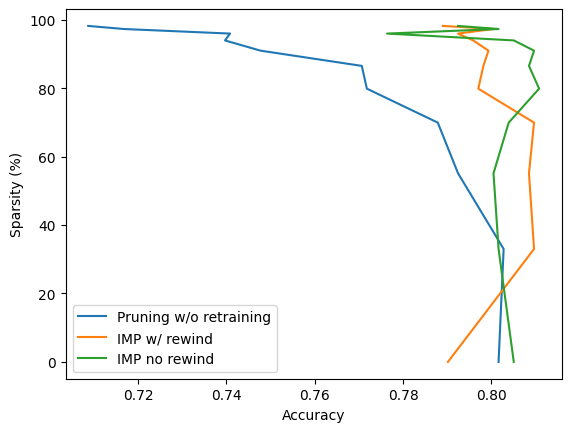

In [43]:
import matplotlib.pyplot as plt

# x: acc, y: sparsity
plt.plot(sst_pruned_df['Accuracy'], sst_pruned_df['Sparsity (%)'], color="C0", label="Pruning w/o retraining")
plt.plot(sst_imp_rewind_df['Accuracy'], sst_imp_rewind_df['Sparsity (%)'], color="C1", label="IMP w/ rewind")
plt.plot(sst_imp_no_rewind_df['Accuracy'], sst_imp_no_rewind_df['Sparsity (%)'], color="C2", label="IMP no rewind")
plt.legend()
plt.xlabel("Accuracy")
plt.ylabel("Sparsity (%)")
# YOUR CODE for titles and axis labels, etc.
plt.show()

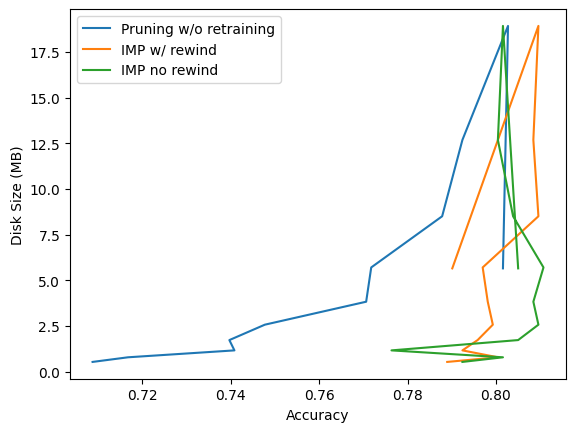

In [44]:
# x: acc, y: disk space
plt.plot(sst_pruned_df['Accuracy'], sst_pruned_df['Disk Size (MB)'], color="C0", label="Pruning w/o retraining")
plt.plot(sst_imp_rewind_df['Accuracy'], sst_imp_rewind_df['Disk Size (MB)'], color="C1", label="IMP w/ rewind")
plt.plot(sst_imp_no_rewind_df['Accuracy'], sst_imp_no_rewind_df['Disk Size (MB)'], color="C2", label="IMP no rewind")
plt.legend()
plt.xlabel("Accuracy")
plt.ylabel("Disk Size (MB)")

plt.show()

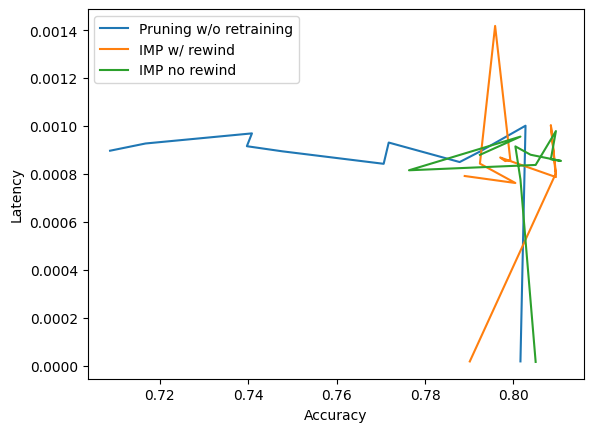

In [45]:
# x: acc, y: latency
plt.plot(sst_pruned_df['Accuracy'], sst_pruned_df['Latency'], color="C0", label="Pruning w/o retraining")
plt.plot(sst_imp_rewind_df['Accuracy'], sst_imp_rewind_df['Latency'], color="C1", label="IMP w/ rewind")
plt.plot(sst_imp_no_rewind_df['Accuracy'], sst_imp_no_rewind_df['Latency'], color="C2", label="IMP no rewind")
plt.legend()
plt.xlabel("Accuracy")
plt.ylabel("Latency")
plt.show()
